In [1]:
import re
import os
import string

%matplotlib inline

import numpy as np
import pandas as pd
import pylab as P
import matplotlib.pyplot as plt
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem.lancaster import LancasterStemmer
from collections import Counter

plt.style.use('ggplot')
plt.rcParams['font.size'] = 15
pd.set_option('max_colwidth',30)

## Read the emails files in allen-p folder and build dataframe

In [2]:
path = 'enron/allen-p/_sent_mail/'

# To extract five data: email from, enail to, subject, email text, sent date
from_list = []
to_list = []
subject_list = []
date_list = []
text_list = []

# Regular expression to extract data
for file in os.listdir(path):
    with open(os.path.join(path, file), 'r') as content_file:
        content = content_file.read()
        # From
        from_list.append(re.findall('[\n\r].*From: \s*([^\n\r]*)', content)[0])
        # To
        to_list.append(re.findall('[\n\r].*To: \s*([^\n\r]*)', content)[0])
        # Subject
        subject = re.findall('Subject: (?s)(.*)Mime-Version', content)[0]
        subject = subject.replace('\n', '')
        subject_list.append(subject)
        # Date
        date_list.append(re.findall('[\n\r].*Date: \s*([^\n\r]*)', content)[0])
        # Email text
        text_original = re.findall("(?<=X-FileName:)[.|\n|\W|\w]*", content)[0]
        text = text_original.replace('\n', '')
        text = text.replace('pallen (Non-Privileged).pst', '')
        text = text.replace('pallen.nsf', '')
        text_list.append(text)

# Using 5 lists to build Pandas DataFrame
data = {'From': from_list, 'To': to_list, 'Subject': subject_list, 'Date': date_list, 'Text': text_list}

df = pd.DataFrame(data, columns=['From', 'To', 'Subject', 'Date', 'Text'])
df = df.replace('', np.nan, regex=True)

## The first 10 rows in the DataFrame, with 5 columns

In [3]:
df.head(10)

,From,To,Subject,Date,Text
0,phillip.allen@enron.com,tim.belden@enron.com,NaN,"Mon, 14 May 2001 16:39:00 ...",Here is our forecast
1,phillip.allen@enron.com,john.lavorato@enron.com,Re:,"Fri, 4 May 2001 13:51:00 -...",Traveling to have a busin...
2,phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,"Wed, 18 Oct 2000 03:00:00 ...",test successful. way to ...
3,phillip.allen@enron.com,randall.gay@enron.com,NaN,"Mon, 23 Oct 2000 06:13:00 ...","Randy, Can you send me a ..."
4,phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,"Thu, 31 Aug 2000 05:07:00 ...",Let's shoot for Tuesday a...
5,phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,"Thu, 31 Aug 2000 04:17:00 ...","Greg, How about either ne..."
6,phillip.allen@enron.com,"david.l.johnson@enron.com,...",NaN,"Tue, 22 Aug 2000 07:44:00 ...",Please cc the following d...
7,phillip.allen@enron.com,joyce.teixeira@enron.com,Re: PRC review - phone calls,"Fri, 14 Jul 2000 06:59:00 ...",any morning between 10 an...
8,phillip.allen@enron.com,mark.scott@enron.com,Re: High Speed Internet Ac...,"Tue, 17 Oct 2000 02:26:00 ...",1. login: pallen pw: ke9...
9,phillip.allen@enron.com,zimam@enron.com,FW: fixed forward or other...,"Mon, 16 Oct 2000 06:44:00 ...",---------------------- Fo...


## Have a look at the basic information in DataFrame
- 602 emails, 175 of which have no subjects

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 602 entries, 0 to 601
Data columns (total 5 columns):
From       602 non-null object
To         602 non-null object
Subject    427 non-null object
Date       602 non-null object
Text       602 non-null object
dtypes: object(5)
memory usage: 16.5+ KB


## Look at each column
- phillip.allen used 2 email address, mostly "phillip.allen@enron.com"
- phillip.allen sent to 206 addresses, the most cotact is "stagecoachmama"
- phillip.allen sent 2 emails per day at most

In [5]:
df.describe()

,From,To,Subject,Date,Text
count,602,602,427,602,602
unique,2,206,323,593,580
top,phillip.allen@enron.com,stagecoachmama@hotmail.com,Re:,"Tue, 6 Jun 2000 05:27:00 -...","Johnnie,Thank you for mee..."
freq,598,40,30,2,2


## To calsulate the frequencies of emails sent to

In [6]:
df_to = df.dropna(subset=['To'])

# select the top 20
df['To'].value_counts()[:20]

stagecoachmama@hotmail.com                       40
jsmith@austintx.com                              38
ina.rangel@enron.com                             37
pallen70@hotmail.com                             28
keith.holst@enron.com                            24
cbpres@austin.rr.com                             20
john.lavorato@enron.com                          16
maryrichards7@hotmail.com                        15
jacquestc@aol.com                                14
mike.grigsby@enron.com                           13
llewter@austin.rr.com                            10
rlehmann@yahoo.com                                8
stouchstone@natsource.com                         7
jeff.richter@enron.com                            6
mac.d.hargrove@rssmb.com                          6
matthew.lenhart@enron.com                         6
andrea.richards@enron.com                         6
mike.grigsby@enron.com, keith.holst@enron.com     6
gthorse@keyad.com                                 5
al.pollard@e

## Extract features from email address
- domain name of each email address
- contact name or user name of each email address
- add 2 new columns

In [7]:
pattern = r'([A-Z0-9._%+-]+)@([A-Z0-9.-]+)\.([A-Z]{2,4})'
regex = re.compile(pattern, flags=re.IGNORECASE)
organizations = []
contact = []
for email in df['To']:
    if regex.match(email):
        organizations.append(regex.match(email).groups()[1])
        contact.append(regex.match(email).groups()[0])
    else:
        organizations.append('')
        contact.append('')

df['ToOrganization'] = organizations
df['Contact'] = contact
df.head(10)

,From,To,Subject,Date,Text,ToOrganization,Contact
0,phillip.allen@enron.com,tim.belden@enron.com,NaN,"Mon, 14 May 2001 16:39:00 ...",Here is our forecast,enron,tim.belden
1,phillip.allen@enron.com,john.lavorato@enron.com,Re:,"Fri, 4 May 2001 13:51:00 -...",Traveling to have a busin...,enron,john.lavorato
2,phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,"Wed, 18 Oct 2000 03:00:00 ...",test successful. way to ...,enron,leah.arsdall
3,phillip.allen@enron.com,randall.gay@enron.com,NaN,"Mon, 23 Oct 2000 06:13:00 ...","Randy, Can you send me a ...",enron,randall.gay
4,phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,"Thu, 31 Aug 2000 05:07:00 ...",Let's shoot for Tuesday a...,enron,greg.piper
5,phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,"Thu, 31 Aug 2000 04:17:00 ...","Greg, How about either ne...",enron,greg.piper
6,phillip.allen@enron.com,"david.l.johnson@enron.com,...",NaN,"Tue, 22 Aug 2000 07:44:00 ...",Please cc the following d...,enron,david.l.johnson
7,phillip.allen@enron.com,joyce.teixeira@enron.com,Re: PRC review - phone calls,"Fri, 14 Jul 2000 06:59:00 ...",any morning between 10 an...,enron,joyce.teixeira
8,phillip.allen@enron.com,mark.scott@enron.com,Re: High Speed Internet Ac...,"Tue, 17 Oct 2000 02:26:00 ...",1. login: pallen pw: ke9...,enron,mark.scott
9,phillip.allen@enron.com,zimam@enron.com,FW: fixed forward or other...,"Mon, 16 Oct 2000 06:44:00 ...",---------------------- Fo...,enron,zimam


## Calculate the most sent domain name
- may be the organization name

In [8]:
# select the top 20
df['ToOrganization'].value_counts()[:20]

enron                343
hotmail               87
austintx              38
austin.rr             32
aol                   14
yahoo                 12
natsource              7
keyad                  7
intelligencepress      7
rssmb                  6
caprock                4
creativepanel          4
webtv                  3
thedoghousemail        3
spbank                 2
juno                   2
sempratrading          2
thermon                2
ev1                    2
pdq                    2
Name: ToOrganization, dtype: int64

## Calculate the most contact person

In [9]:
# select the top 20
df['Contact'].value_counts()[:20]

stagecoachmama     40
ina.rangel         38
jsmith             38
mike.grigsby       30
pallen70           28
keith.holst        28
cbpres             22
john.lavorato      16
maryrichards7      15
jacquestc          14
matthew.lenhart    12
llewter            11
jeff.richter        9
rlehmann            8
stouchstone         7
tim.belden          6
gthorse             6
andrea.richards     6
mac.d.hargrove      6
frank.ermis         5
Name: Contact, dtype: int64

## Analyze email main text
- Process main text by Natural language processing
- Count the words frequencies
- The preparation for more analysis like sentiment analysis

In [10]:
# Randomly select text in one email
# Turn to lower case
email_text = df['Text'][500].lower()
# Remove punctuation
words = "".join([ch for ch in email_text if ch not in string.punctuation])
# Split the words
tokens = nltk.word_tokenize(words)
# Remove stop words
filtered = [w for w in tokens if not w in stopwords.words('english')]
# Code for stemming used in predition
# lanste = LancasterStemmer()
# stemmed = [lanste.stem(i) for i in filtered]

# Count top 10 used words
count = Counter(filtered)
count.most_common(10)

[('draft', 3),
 ('divert', 3),
 ('mbd', 2),
 ('physically', 2),
 ('0817', 2),
 ('pm', 2),
 ('phillip', 2),
 ('short', 2),
 ('sentence', 2),
 ('oraturn', 2)]

## Select the most frequently contact "stagecoachmama"
- All emails between stagecoachmama and phillip.allen
- Count wodrs phillip.allen like to use in the emails to stagecoachmama

In [11]:
# Group the DataFrame by 'Contact' column and combine all text to 'stagecoachmama'
email_text = (" ").join(df.groupby('Contact')['Text'].apply(list)['stagecoachmama'])

# The same process as before
words = "".join([ch for ch in email_text if ch not in string.punctuation])
tokens = nltk.word_tokenize(words)
filtered = [w for w in tokens if not w in stopwords.words('english')]
# lanste = LancasterStemmer()
# stemmed = [lanste.stem(i) for i in filtered]
count = Counter(filtered)
words_used = count.most_common(20)
words_used

[('I', 68),
 ('rent', 23),
 ('need', 21),
 ('paid', 21),
 ('rentroll', 21),
 ('email', 17),
 ('Lucy', 17),
 ('get', 16),
 ('file', 13),
 ('week', 13),
 ('questions', 12),
 ('If', 12),
 ('The', 12),
 ('tenants', 12),
 ('pay', 12),
 ('missed', 11),
 ('going', 10),
 ('It', 10),
 ('You', 10),
 ('want', 10)]

## A simple visulization about last result

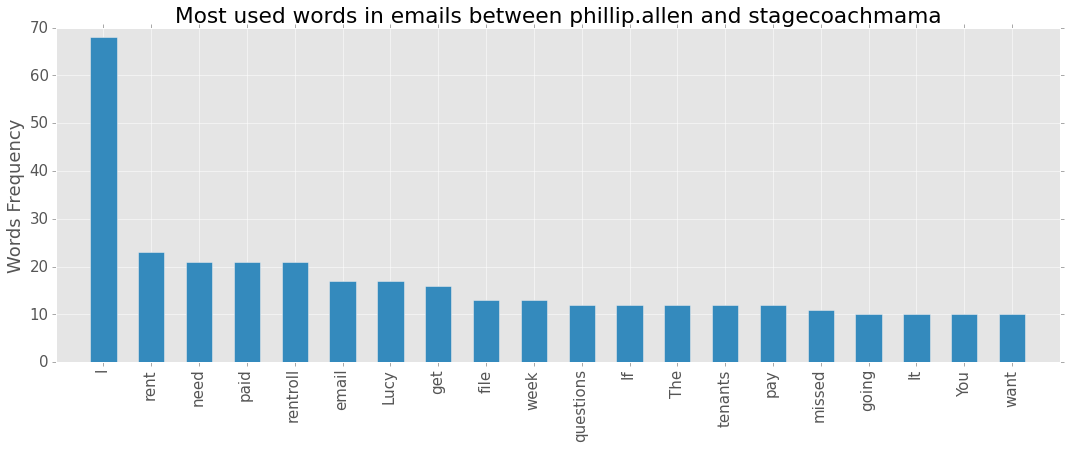

In [12]:
fig = plt.figure(figsize=(18,6), dpi=1600) 
x_val = [x[0] for x in words_used]
y_val = [x[1] for x in words_used]

ind = np.arange(len(x_val))

plt.bar(ind, y_val, width=0.55, align='center')
plt.xticks(ind, x_val, rotation='vertical')
plt.xlim(-1, 20)
plt.ylabel("Words Frequency")
plt.title("Most used words in emails between phillip.allen and stagecoachmama")
plt.show()

## What can be done next?
### For example, sentiment analysis
- Find a email datasets containing the sentiment classification
- Build classification model from this datasets
- Use this model to predict the email text of phillip.allen
- Get a sentiment prediction to show the emotion of phillip.allen when he wrote emails to every one in the datasets

## What can be improved?
### Many, like
- multi email addresses in 'To' column
- Remove the forward information in email main text
- parse the date
- extract more features, like identifying whether it's a reply, forward or new email.